In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import f

In [2]:
#读取数据并处理编码问题
try:
    df = pd.read_csv("数字经济发展与企业创新.csv", encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv("数字经济发展与企业创新.csv", encoding='gbk')

#筛选2017年的数据
df_2017 = df[df['year'] == 2017].copy()

In [3]:

def perform_regression(data, independent_var, dependent_var, threshold_var, threshold, controls=[]):
    """
    执行分组回归并返回带稳健标准误的结果
    """
    # 创建分组变量
    data['region1'] = (data[threshold_var] < threshold).astype(int)
    data['region2'] = (data[threshold_var] >= threshold).astype(int)
    data['dige1'] = data['region1'] * data[dependent_var]
    data['dige2'] = data['region2'] * data[dependent_var]
    
    # 构造回归模型
    X = data[['dige1', 'dige2'] + controls]
    X = sm.add_constant(X)  # 添加常数项
    y = data[independent_var]
    
    # 使用 OLS 进行回归
    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    
    # 返回带稳健标准误的结果
    robust_results = results.get_robustcov_results(cov_type='HC0')  # HC0 是 White 的稳健标准误方法
    return robust_results

#计算门限值和F统计量
def calculate_threshold_and_f1(data, independent_var, dependent_var, threshold_var, controls=[]):
    thresholds = sorted(data[threshold_var].dropna().unique())
    f1_statistics = []
    p_values = []

    #基准模型
    X_base = sm.add_constant(data[controls])  #控制变量
    y = data[independent_var]
    base_model = sm.OLS(y, X_base, missing='drop').fit()
    s0 = base_model.ssr  #无门限模型的残差平方和

    for threshold in thresholds:
        results = perform_regression(data, independent_var, dependent_var, threshold_var, threshold, controls)
        s1_gamma = results.ssr  #当前门限值下的残差平方和
        sigma2 = s1_gamma / (len(data) - len(controls) - 3)  #残差方差估计
        f1_stat = (s0 - s1_gamma) / sigma2  #F统计量
        f1_statistics.append(f1_stat)
        # p值
        df_num = 1  # F统计量的分子自由度
        df_denom = len(data) - len(controls) - 3  # F统计量的分母自由度
        p_value = 1 - f.cdf(f1_stat, df_num, df_denom) 
        p_values.append(p_value)
    
    min_f1_stat = -max(f1_statistics) 
    f1_statistics_symmetric = [-y + (-min_f1_stat) for y in f1_statistics] 

    min_f1_symmetric = min(f1_statistics_symmetric) 
    best_threshold = thresholds[np.argmin(f1_statistics_symmetric)]  

    max_f1_symmetric = max(f1_statistics_symmetric) 
    best_threshold_max = thresholds[np.argmax(f1_statistics_symmetric)] 
    max_f1_p_symmetric = p_values[np.argmax(f1_statistics_symmetric)] 
    
    return thresholds, f1_statistics, p_values, f1_statistics_symmetric, best_threshold, min_f1_symmetric, best_threshold_max, max_f1_symmetric, max_f1_p_symmetric

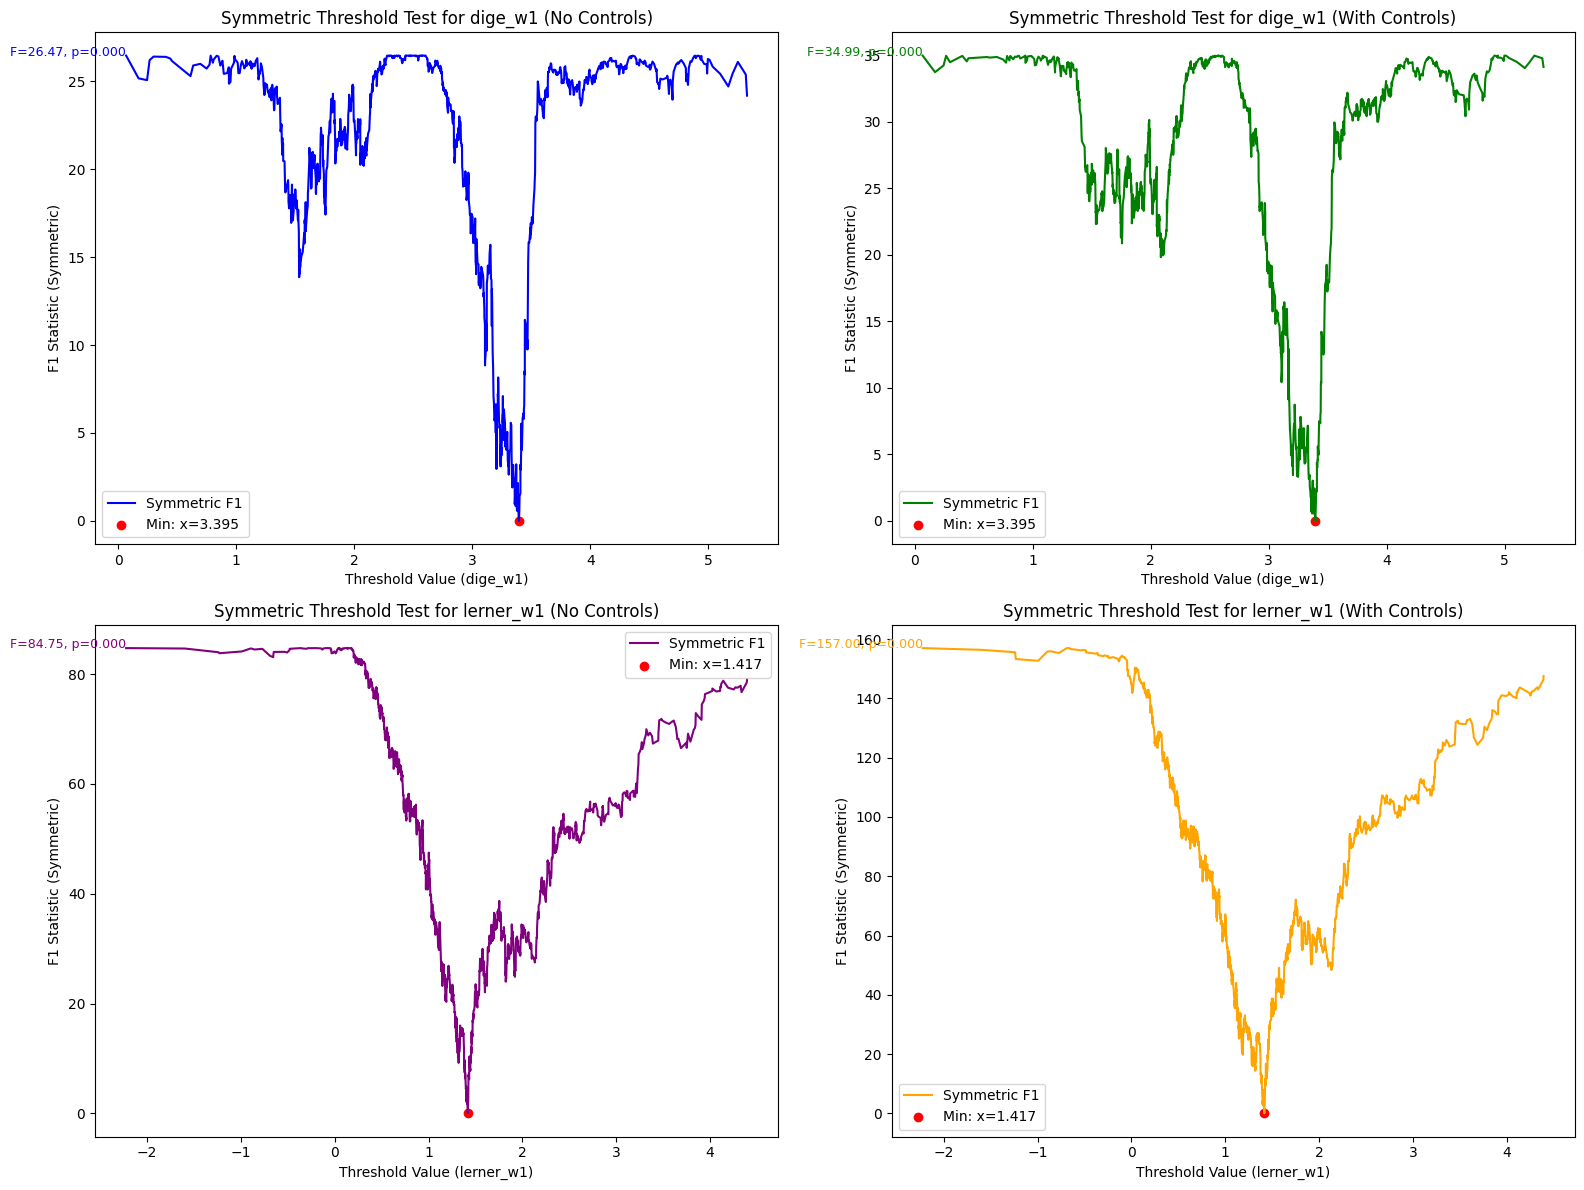

Symmetric Highest F for dige_w1 (No Controls): F=26.467, p=0.000
Symmetric Highest F for dige_w1 (With Controls): F=34.992, p=0.000
Symmetric Highest F for lerner_w1 (No Controls): F=84.753, p=0.000
Symmetric Highest F for lerner_w1 (With Controls): F=156.999, p=0.000


In [4]:
#控制变量
controls = ['bsize_w1', 'post_w1', 'bodi_w1', 'age_w1', 'fixpro_w1', 
            'exp_w1', 'flows_w1', 'subsidies_w1', 'profit_w1']

# 模型计算
thresholds_dige, f1_statistics_dige, p_values_dige, f1_statistics_dige_symmetric, best_threshold_dige, min_f1_dige_symmetric, best_threshold_max_dige, max_f1_dige_symmetric, max_f1_p_dige_symmetric = calculate_threshold_and_f1(
    df_2017, independent_var='inv_w1', dependent_var='dige_w1', threshold_var='dige_w1', controls=[]
)

thresholds_dige_controls, f1_statistics_dige_controls, p_values_dige_controls, f1_statistics_dige_controls_symmetric, best_threshold_dige_controls, min_f1_dige_controls_symmetric, best_threshold_max_dige_controls, max_f1_dige_controls_symmetric, max_f1_p_dige_controls_symmetric = calculate_threshold_and_f1(
    df_2017, independent_var='inv_w1', dependent_var='dige_w1', threshold_var='dige_w1', controls=controls
)

thresholds_lerner, f1_statistics_lerner, p_values_lerner, f1_statistics_lerner_symmetric, best_threshold_lerner, min_f1_lerner_symmetric, best_threshold_max_lerner, max_f1_lerner_symmetric, max_f1_p_lerner_symmetric = calculate_threshold_and_f1(
    df_2017, independent_var='inv_w1', dependent_var='dige_w1', threshold_var='lerner_w1', controls=[]
)

thresholds_lerner_controls, f1_statistics_lerner_controls, p_values_lerner_controls, f1_statistics_lerner_controls_symmetric, best_threshold_lerner_controls, min_f1_lerner_controls_symmetric, best_threshold_max_lerner_controls, max_f1_lerner_controls_symmetric, max_f1_p_lerner_controls_symmetric = calculate_threshold_and_f1(
    df_2017, independent_var='inv_w1', dependent_var='dige_w1', threshold_var='lerner_w1', controls=controls
)


plt.figure(figsize=(16, 12))

#dige_w1 + 无控制变量
plt.subplot(2, 2, 1)
plt.plot(thresholds_dige, f1_statistics_dige_symmetric, label='Symmetric F1', color='blue')
plt.scatter(best_threshold_dige, min_f1_dige_symmetric, color='red', label=f'Min: x={best_threshold_dige:.3f}')
plt.text(best_threshold_max_dige, max_f1_dige_symmetric, f"F={max_f1_dige_symmetric:.2f}, p={max_f1_p_dige_symmetric:.3f}", 
         color='blue', fontsize=9, ha='right')
plt.title('Symmetric Threshold Test for dige_w1 (No Controls)')
plt.xlabel('Threshold Value (dige_w1)')
plt.ylabel('F1 Statistic (Symmetric)')
plt.legend()

# dige_w1 + 控制变量
plt.subplot(2, 2, 2)
plt.plot(thresholds_dige_controls, f1_statistics_dige_controls_symmetric, label='Symmetric F1', color='green')
plt.scatter(best_threshold_dige_controls, min_f1_dige_controls_symmetric, color='red', label=f'Min: x={best_threshold_dige_controls:.3f}')
plt.text(best_threshold_max_dige_controls, max_f1_dige_controls_symmetric, f"F={max_f1_dige_controls_symmetric:.2f}, p={max_f1_p_dige_controls_symmetric:.3f}", 
         color='green', fontsize=9, ha='right')
plt.title('Symmetric Threshold Test for dige_w1 (With Controls)')
plt.xlabel('Threshold Value (dige_w1)')
plt.ylabel('F1 Statistic (Symmetric)')
plt.legend()

# lerner_w1 + 无控制变量
plt.subplot(2, 2, 3)
plt.plot(thresholds_lerner, f1_statistics_lerner_symmetric, label='Symmetric F1', color='purple')
plt.scatter(best_threshold_lerner, min_f1_lerner_symmetric, color='red', label=f'Min: x={best_threshold_lerner:.3f}')
plt.text(best_threshold_max_lerner, max_f1_lerner_symmetric, f"F={max_f1_lerner_symmetric:.2f}, p={max_f1_p_lerner_symmetric:.3f}", 
         color='purple', fontsize=9, ha='right')
plt.title('Symmetric Threshold Test for lerner_w1 (No Controls)')
plt.xlabel('Threshold Value (lerner_w1)')
plt.ylabel('F1 Statistic (Symmetric)')
plt.legend()

# lerner_w1 + 控制变量
plt.subplot(2, 2, 4)
plt.plot(thresholds_lerner_controls, f1_statistics_lerner_controls_symmetric, label='Symmetric F1', color='orange')
plt.scatter(best_threshold_lerner_controls, min_f1_lerner_controls_symmetric, color='red', label=f'Min: x={best_threshold_lerner_controls:.3f}')
plt.text(best_threshold_max_lerner_controls, max_f1_lerner_controls_symmetric, f"F={max_f1_lerner_controls_symmetric:.2f}, p={max_f1_p_lerner_controls_symmetric:.3f}", 
         color='orange', fontsize=9, ha='right')
plt.title('Symmetric Threshold Test for lerner_w1 (With Controls)')
plt.xlabel('Threshold Value (lerner_w1)')
plt.ylabel('F1 Statistic (Symmetric)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Symmetric Highest F for dige_w1 (No Controls): F={max_f1_dige_symmetric:.3f}, p={max_f1_p_dige_symmetric:.3f}")
print(f"Symmetric Highest F for dige_w1 (With Controls): F={max_f1_dige_controls_symmetric:.3f}, p={max_f1_p_dige_controls_symmetric:.3f}")
print(f"Symmetric Highest F for lerner_w1 (No Controls): F={max_f1_lerner_symmetric:.3f}, p={max_f1_p_lerner_symmetric:.3f}")
print(f"Symmetric Highest F for lerner_w1 (With Controls): F={max_f1_lerner_controls_symmetric:.3f}, p={max_f1_p_lerner_controls_symmetric:.3f}")

In [5]:
def calculate_s1(data, independent_var, dependent_var, threshold_var, gamma, controls=[]):
    """
    计算 S1(γ)
    """
    #分组变量
    data['region1'] = (data[threshold_var] <= gamma).astype(int)
    data['region2'] = (data[threshold_var] > gamma).astype(int)
    data['dige1'] = data['region1'] * data[dependent_var]
    data['dige2'] = data['region2'] * data[dependent_var]
    
    #回归模型
    X = data[['dige1', 'dige2'] + controls]
    X = sm.add_constant(X)  #常数项
    y = data[independent_var]
    
    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    
    #残差平方和S1(γ)
    residuals = y - results.predict(X)
    s1_gamma = np.sum(residuals**2)
    return s1_gamma

#网格搜参
def grid_search(data, independent_var, dependent_var, threshold_var, controls=[]):
    """
    在所有可能的γ值上搜索S1(γ)的最小值
    """
    thresholds = sorted(data[threshold_var].dropna().unique())
    
    #初始化
    s1_values = []
    for gamma in thresholds:
        s1_gamma = calculate_s1(data, independent_var, dependent_var, threshold_var, gamma, controls)
        s1_values.append(s1_gamma)
    
    min_s1 = min(s1_values)
    best_gamma = thresholds[np.argmin(s1_values)]
    return thresholds, s1_values, best_gamma, min_s1

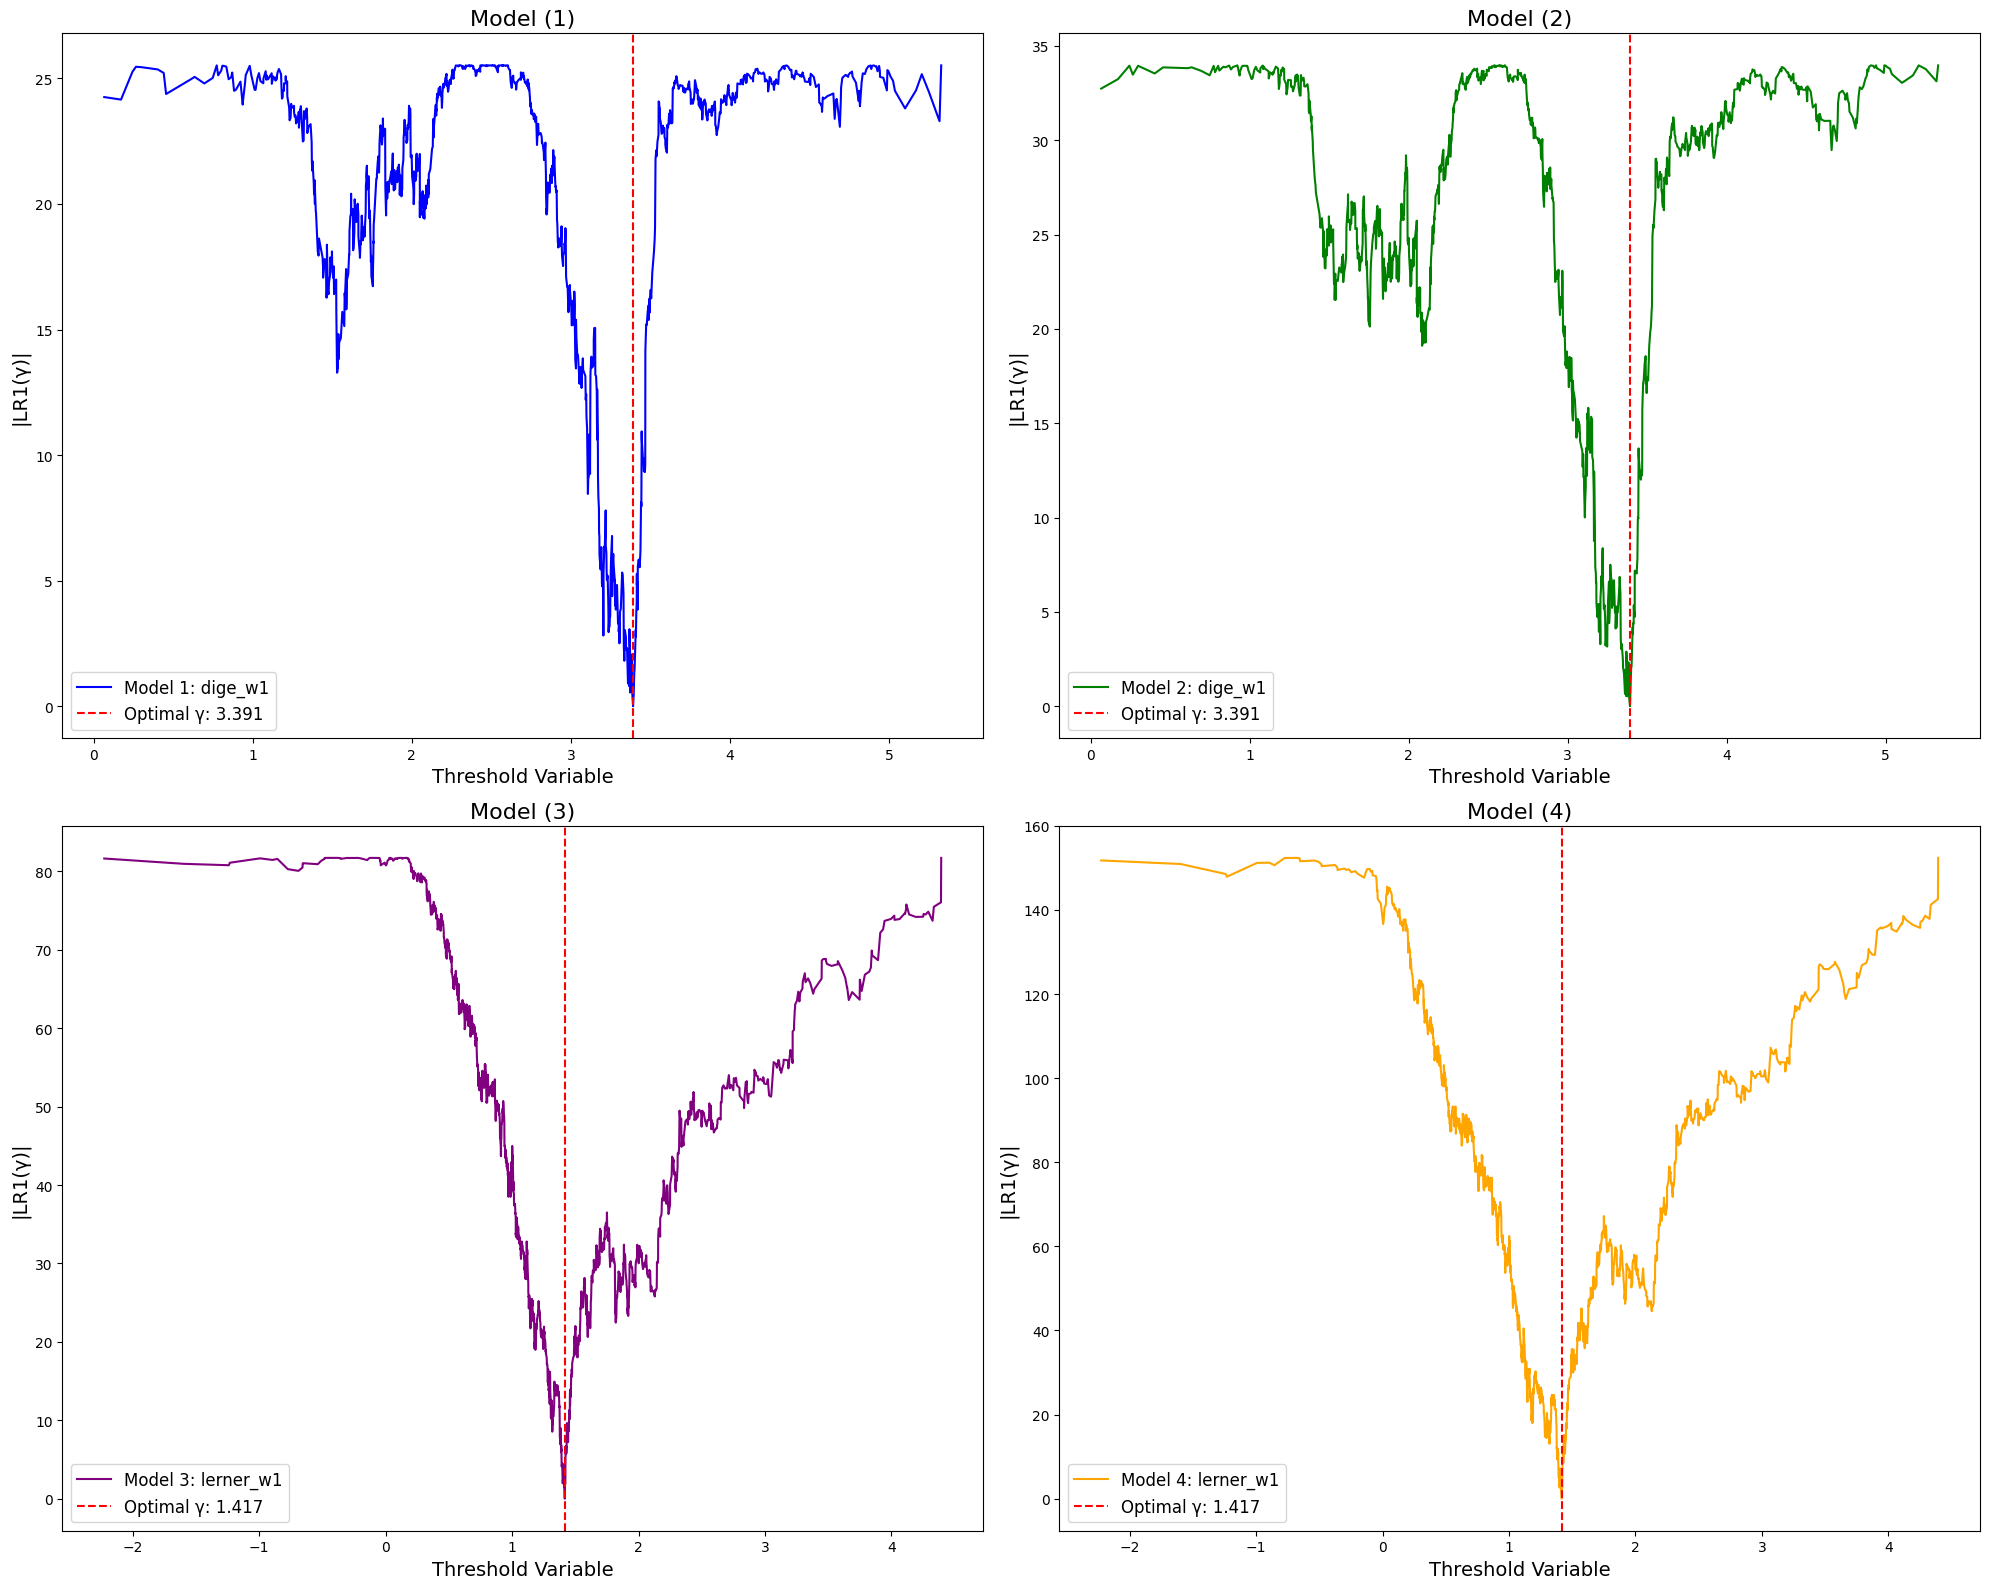

Model (1) - Y-axis Maximum: 25.520
Model (2) - Y-axis Maximum: 33.966
Model (3) - Y-axis Maximum: 81.720
Model (4) - Y-axis Maximum: 152.394


In [6]:
independent_var = 'inv_w1'  
dependent_var = 'dige_w1'  
threshold_var_1 = 'dige_w1'  #门限变量 1
threshold_var_2 = 'lerner_w1'  #门限变量 2

results = []

colors = ['blue', 'green', 'purple', 'orange']
y_axis_max_values = [] 

plt.figure(figsize=(20, 16))  # 调整整个图像的大小

for i, (threshold_var, use_controls) in enumerate([(threshold_var_1, False), (threshold_var_1, True), 
                                                   (threshold_var_2, False), (threshold_var_2, True)]):
    #基准模型SSR
    if use_controls:
        X_base = sm.add_constant(df_2017[controls])
    else:
        X_base = sm.add_constant(pd.DataFrame(index=df_2017.index))  # 无控制变量时仅包含常数项
    
    y_base = df_2017[independent_var]
    model_base = sm.OLS(y_base, X_base, missing='drop').fit()
    s0 = np.sum((y_base - model_base.predict(X_base))**2)
    
    # 网格搜参
    thresholds, s1_values, best_gamma, min_s1 = grid_search(df_2017, independent_var, dependent_var, threshold_var, controls if use_controls else [])
    
    # 计算 |LR1(γ)|
    lr_values = [abs((min_s1 - s1) / (min_s1 / (len(df_2017) - len(controls) - 3))) for s1 in s1_values]
    y_axis_max_values.append(max(lr_values))  
    
    # 绘制图像
    plt.subplot(2, 2, i+1)
    plt.plot(thresholds, lr_values, color=colors[i], label=f"Model {i+1}: {threshold_var}")
    plt.axvline(x=best_gamma, color='red', linestyle='--', label=f'Optimal γ: {best_gamma:.3f}')
    plt.title(f'Model ({i+1})', fontsize=16)
    plt.xlabel('Threshold Variable', fontsize=14)
    plt.ylabel('|LR1(γ)|', fontsize=14)
    plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#输出
for result in results:
    print(f"Model ({result['model']}) - Threshold Variable: {result['threshold_var']}")
    print(f"  Optimal Threshold (γ): {result['best_gamma']:.3f}")
    print(f"  Min S1(γ): {result['min_s1']:.3f}")
    print(f"  F1 Statistic: {result['f1']:.3f}")
    print(f"  LR1 Statistic: {result['lr1']:.3f}")
    print()

for i, max_value in enumerate(y_axis_max_values, start=1):
    print(f"Model ({i}) - Y-axis Maximum: {max_value:.3f}")

In [7]:
# 函数：构建分组变量并进行回归分析
# 第一部分：仅考虑数字经济变量 dige_w1 的回归
threshold_dige = 3.395
results1 = perform_regression(df_2017, independent_var='inv_w1', dependent_var='dige_w1', 
                              threshold_var='dige_w1', threshold=threshold_dige)

print("Regression Results 1 (2017, Threshold on dige_w1):")
print(results1.summary())

# 第二部分：加入控制变量后的回归
controls = ['bsize_w1', 'post_w1', 'bodi_w1', 'age_w1', 'fixpro_w1', 
            'exp_w1', 'flows_w1', 'subsidies_w1', 'profit_w1']

results2 = perform_regression(df_2017, independent_var='inv_w1', dependent_var='dige_w1', 
                              threshold_var='dige_w1', threshold=threshold_dige, controls=controls)

print("\nRegression Results 2 (2017, Threshold on dige_w1 with controls):")
print(results2.summary())

# 第三部分：以 lerner_w1 为分组变量
threshold_lerner = 1.417
results3 = perform_regression(df_2017, independent_var='inv_w1', dependent_var='dige_w1', 
                              threshold_var='lerner_w1', threshold=threshold_lerner)

print("\nRegression Results 3 (2017, Threshold on lerner_w1):")
print(results3.summary())

# 第四部分：以 lerner_w1 为分组变量并加入控制变量后的回归
results4 = perform_regression(df_2017, independent_var='inv_w1', dependent_var='dige_w1', 
                              threshold_var='lerner_w1', threshold=threshold_lerner, controls=controls)

print("\nRegression Results 4 (2017, Threshold on lerner_w1 with controls):")
print(results4.summary())

Regression Results 1 (2017, Threshold on dige_w1):
                            OLS Regression Results                            
Dep. Variable:                 inv_w1   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     46.13
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           2.61e-20
Time:                        12:24:26   Log-Likelihood:                -3676.2
No. Observations:                1995   AIC:                             7358.
Df Residuals:                    1992   BIC:                             7375.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c